<xarray.DataArray 'mask' (latitude: 66, longitude: 119)>
array([[1.  , 1.  , 1.  , ..., 0.75, 0.75, 0.75],
       [1.  , 1.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])
Coordinates:
  * longitude  (longitude) float32 60.75 61.5 62.25 63.0 ... 147.75 148.5 149.25
  * latitude   (latitude) float32 59.25 58.5 57.75 57.0 ... 12.0 11.25 10.5
    time       datetime64[ns] 2018-02-01
    mask       (latitude, longitude) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0


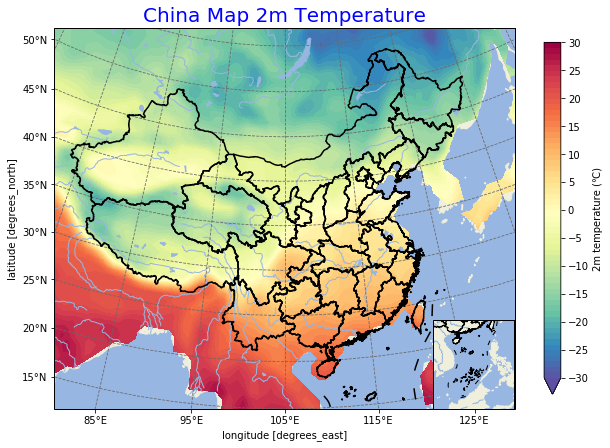

In [2]:
# https://gnss.help/2018/04/24/cartopy-gallery/index.html
# http://www.meteo.mcgill.ca/~cmccray/python.html
# https://www.jianshu.com/p/6506691f0788
# https://nbviewer.jupyter.org/gist/ajdawson/dd536f786741e987ae4e
# https://gmt-china.org/data/CN-border-La.dat
import numpy as np
import os,sys
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from copy import copy
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import shapely.geometry as sgeom


def find_side(ls, side):
    """
 Given a shapely LineString which is assumed to be rectangular, return the
 line corresponding to a given side of the rectangle.

 """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])

def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible: 
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels


# Load the border data, CN-border-La.dat is downloaded from
# https://gmt-china.org/data/CN-border-La.dat
with open('CN-border-La.dat') as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]

    
# Set figure size
proj = ccrs.LambertConformal(central_longitude=105, central_latitude=90,
                             false_easting=400000, false_northing=400000)#,standard_parallels=(46, 49))

fig = plt.figure(figsize=[10, 8],frameon=True)

# Set projection and plot the main figure
ax = fig.add_axes([0.08, 0.05, 0.8, 0.94], projection=proj)
# Set figure extent
ax.set_extent([80, 130, 15, 55],crs=ccrs.PlateCarree())
# ax.set_title('ChinaChinaChinaChinaChinaChinaChinaChinaChinaChina',fontsize=20)       
# Plot border lines
for line in borders:
    ax.plot(line[0::2], line[1::2], '-', lw=1.5, color='k',
            transform=ccrs.Geodetic())

# Add ocean, land, rivers and lakes
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.RIVERS.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))


# *must* call draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()

# Define gridline locations and draw the lines using cartopy's built-in gridliner:
# xticks = np.arange(80,130,10)
# yticks = np.arange(15,55,5)
xticks = [55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165]
yticks = [0 , 5 , 10, 15, 20, 25 , 30 , 35 , 40 , 45 , 50 , 55 , 60 , 65]
ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=1,color='dimgrey')

# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

# https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
# ax.set_aspect('auto', adjustable=None)

lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks)

#Plot South China Sea as a subfigure
sub_ax = fig.add_axes([0.592, 0.189, 0.14, 0.155],
                      projection=ccrs.LambertConformal(central_latitude=90,
                                                       central_longitude=115))
# Add ocean, land, rivers and lakes
sub_ax.add_feature(cfeature.OCEAN.with_scale('50m'))
sub_ax.add_feature(cfeature.LAND.with_scale('50m'))
sub_ax.add_feature(cfeature.RIVERS.with_scale('50m'))
sub_ax.add_feature(cfeature.LAKES.with_scale('50m'))
# Plot border lines
for line in borders:
    sub_ax.plot(line[0::2], line[1::2], '-', lw=1, color='k',
                transform=ccrs.Geodetic())
# Set figure extent
sub_ax.set_extent([105, 125, 0, 25],crs=ccrs.PlateCarree())

def mask(ds, label='land'):
    landsea = xr.open_dataset('landsea.nc')
    landsea = landsea['LSMASK']
    # --ds和地形数据分辨率不一致，需将地形数据插值
    landsea = landsea.interp(lat=ds.latitude.values, lon=ds.longitude.values)
    # --利用地形掩盖海陆数据
    ds.coords['mask'] = (('latitude', 'longitude'), landsea.values)
    print(ds.mask)
    if label == 'land':
        ds = ds.where(ds.mask < 0.8) #可以尝试调整default：0.8
    elif label == 'ocean':
        ds = ds.where(ds.mask > 0.3) #可以尝试调整default：0.2
    return ds

ds = xr.open_dataset('EC-Interim_monthly_2018.nc')
lat = ds.latitude
lon = ds.longitude
time = ds.time
temp = (ds['t2m'] - 273.15) # 把温度转换为℃
# 区域选择
lon_range = lon[(lon>60) & (lon<150)]
lat_range = lat[(lat>10) & (lat<60)]
temp_region = temp.sel(longitude=lon_range, latitude=lat_range, time='2018-02-01')
temp_mask = mask(temp_region, 'ocean')
# 设置colorbar 
#get size and extent of axes:

cbar_kwargs = {
    'orientation': 'vertical',
    'label': '2m temperature (℃)',
    'shrink': 0.8,
    'ticks': np.arange(-30, 30 + 5, 5),
    'pad': 0.05,
    'shrink': 0.65
}


# 画图
levels = np.arange(-30, 30 + 1, 1)
temp_mask.plot.contourf(ax=ax, levels=levels, cmap='Spectral_r',
                        cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree())
# 设置标题的在代码中放置的位置很关键，注意不要放置在小图上或者新建画框了。
ax.set_title('China Map 2m Temperature',color='blue',fontsize= 20)

# Save & Show figure
# (filename, extension) = os.path.splitext(os.path.basename(sys.argv[0]))
plt.savefig("land_sea_mask_simple_lambert.png", dpi=500, bbox_inches='tight')
plt.show()